# In this notbeook threse is an application of the CrossCorrelation module



In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import glob
import os
from skimage import io
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import sys
sys.path.insert(0,'/media/DATA/jbonato/astro_segm/U-net/modules/')
from CC import *
from test_fun import gen_sc_mask


## Rocording loading


In [4]:
device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
num = '2'
query = '00'+num
stack_path = '/media/DATA/jbonato/segm_project/set/'+num+'/'
item = glob.glob(stack_path+'*')
stack_o = io.imread(item[0])

In [5]:
plot_video = False
if plot_video:
    im_list = []
    for i in range(100):
        im_list.append(stack_o[i,:,:])

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(i, animated=True)] for i in im_list]

    ani = animation.ArtistAnimation(fig, ims, interval=1, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

    


In [6]:
frame,N,M = stack_o.shape
mask = np.zeros((N,M,2))
Res_file_path='/media/DATA/jbonato/segm_project/U-net/Results/dense_up/SMALL_'+query+'.hdf5'
dset= h5py.File(Res_file_path,'r') 
mask[:,:,0] =  np.asarray(dset['Values'])
mask[:,:,1] =  np.asarray(dset['Values_soma'])
mask_pl = mask.copy()
mask[:4,:,:]=0
mask[-4:,:,:]=0
mask[:,:4,:]=0
mask[:,-4:,:]=0
### insert the mask splitter
mask_p = np.zeros((N,M,3))
mask_p[:,:,0]= mask[:,:,0]
mask_p[:,:,1]= mask[:,:,1]              

In [7]:
#

mask_sp = gen_sc_mask(mask)

In [8]:
r = 60


print(10*'/','CORR ANALysis',10*'/')

stack = stack_o[:,:,:].copy()

print(stack.flags['C_CONTIGUOUS'])

####old
mask_test_corr = np.empty((2,N,M))
mask_test_corr[0,:,:] = mask[:,:,0]
mask_test_corr[1,:,:] = mask[:,:,1]

coord_st_l = []
coord_cir_l = []
for j in range(mask_sp.shape[0]):
    a,b,_ = create_bb_coord_correlation(np.sum(mask_sp[j,:,:,:],axis=2)) 
    coord_st_l.append(a[0])
    coord_cir_l.append(b[0])


err_corr = comp_err_correlation(coord_st_l,coord_cir_l,stack,mask_sp)
th_corr =err_corr.find_threshold()

#######################

mask_out  = np.zeros((256,256))
mask_out2  = np.zeros((256,256))
mask_single_corr = np.zeros((120,120,len(coord_st_l)))
mask_single_corr2 = np.zeros((120,120,len(coord_st_l)))

for j in range(mask_sp.shape[0]):
    
    #########################################pick coord
    coord_bb = coord_st_l[j]
    
    ########################################define buffer
    mask_crop = np.zeros((2,r*2,r*2))
    mask_crop[0,:,:] = mask_sp[j,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2],0]
    mask_crop[1,:,:] = mask_sp[j,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2],1]
    
    ########################################define stack for cross corr
    stack_crop = np.empty((frame,120,120))
    stack_crop = stack[:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]].copy()
    
    #########################################definr map for selected pixels
    map_ = np.zeros((256,256))
    map_[coord_cir_l[j][0],coord_cir_l[j][1]]=1

    ###### filter the corners from the stack and from buff mask other cell segmentation 
    stack_crop = stack_crop*map_[coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]]
    

    if np.sum(mask_sp[j,:,:,0])!=0 and np.sum(mask_sp[j,:,:,1])!=0: 
       
        out_tensor = corr_mask(mask_crop,stack_crop,device1,th_corr)
        out_tensor_np = out_tensor[0,:,:].data.cpu().numpy()# + out_tensor[1,:,:].data.cpu().numpy()
        out__ = out_tensor[0,:,:].data.cpu().numpy() + out_tensor[1,:,:].data.cpu().numpy()
        del out_tensor
        torch.cuda.empty_cache()
        out_tensor_np = np.nan_to_num(out_tensor_np)
        out_tensor_np[out_tensor_np>1]=1 
        
        mask_out[coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]] +=   out_tensor_np
        out__ = np.nan_to_num(out__)
        out__[out__>1]=1 

        mask_single_corr[:,:,j]=out_tensor_np
        mask_single_corr2[:,:,j]=out__


////////// CORR ANALysis //////////
True
correlation error = 0.048810 with threshold = 0.850000
Reduction finish


## visualization

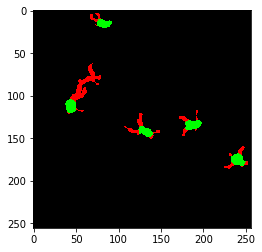

In [9]:
cell = [0,2,4]

plt.imshow(mask_p)

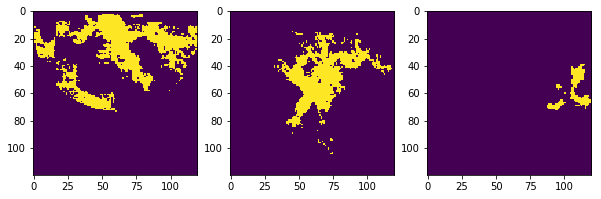

In [10]:
fig,[ax1,ax2,ax3] =plt.subplots(figsize=(10,10),ncols=3,nrows=1)
for j,a in zip(cell,[ax1,ax2,ax3]):
    a.imshow(mask_single_corr[:,:,j])

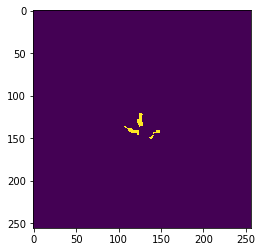

In [12]:
plt.imshow(mask_sp[3,:,:,0])